# What is Dask?

[Dask](https://dask.org/) is a **graph execution engine** that can parallelize computational tasks across the cores of a CPU or across the computers in a cluster in an efficient manner. Moreover, it enables working with data that doesn't fit into the memory. Dask is an open-source project and it already has a proven track record in running on several hundred machine clusters.

![dask logo](assets/dask_logo.svg)

That being said, we don't need to run Dask on a cluster of many computers. As we'll be doing in this module, we can also install Dask into our personal computers and still make use of its capabilities. Our focus in this module will be on using Dask on our computers. Yet, transforming the Dask codes written for a single computer to something that can run on multiple computers requires only a few modifications. Hence, the concepts and techniques we'll learn throughout this module are perfectly applicable to real-world scenarios where task parallelization on a cluster of several machines is needed.

## Why is Dask useful?

So far in this course, you've written code using Pandas, NumPy, and Scikit-learn. With Dask, we'll address three problems that you've most likely come across before:

* You attempted to load a very large dataset into a Pandas dataframe, but you couldn't! This is because, both Pandas and NumPy work on the data that lives in the memory (RAM) of your computer. If the data you want to analyze is larger than the capacity of your RAM, you simply can't load that data into a Pandas dataframe or NumPy array.

* Even though you were able to load a large dataset into a dataframe, some operations took a lot of time.

* You tried to train a machine learning model on a large dataset, but you were disappointed by the never-ending training. One solution to this problem is to run your code across several cores in parallel and Scikit-learn offers single machine parallelization. However, Scikit-learn alone can't scale this parallelization to more than one computer.

Using Dask:

* We can work on datasets that don't fit into our computer's memory.
* We can parallelize Pandas and NumPy functions and methods.
* We can speed up machine learning processes.

In the rest of this module, we'll talk about how we achieve these using Dask one by one. Before that, we want to talk about the basics of Dask.

## Basic properties of Dask

Throughout this module, we'll be using Dask with its high-level abstractions. The main abstractions of Dask work almost the same with the high-level abstractions we get used to:

* Dask dataframes offer us many of the Pandas dataframe operations with a similar set of functions and methods.
* Dask arrays also offer us many of the NumPy array functionalities using a similar set of functions and methods.
* Dask bags mimics the functionalities of plain old Python lists.

All these structures that are offered by Dask enable us to run our code in parallel. Therefore, their familiar apis give us a jump start in using them. Behind the curtain, all these abstractions use low level features that are optimized to be run on multiple cores or even multiple machines. As an example, the image below shows us how Dask dataframe compares to Pandas dataframe:

<img src="assets/dask_dataframe.svg" width="30%" alt="Dask dataframes are blocked Pandas dataframes">
     

As we see, the Dask dataframe actually consists of several Pandas dataframes. So, when we create a Dask dataframe and load some data to it, Dask actually creates a bunch of Pandas dataframes on the background. Each of these dataframes operate in the memory as usual. However, the Dask dataframe coordinates these inner Pandas dataframes so that Dask dataframes can handle very large data even though the data doesn't fit into the memory. We'll talk more about Dask dataframes in the following checkpoint.

A similar thing is also the case for the Dask arrays:

![](assets/dask_array.svg)

Dask is a Python library and prioritizes supporting the existing popular packages like NumPy, Pandas, and Scikit-learn. In doing so, it designs its own apis to mimic the apis of these packages. That's why adopting Dask is easier than adopting other big data tools in the market.

Next, let's see how we can install Dask and then how Dask parallelize tasks.

# Installation

As usual, we'll use `pip` package to install Dask. Dask is comprised of several sub-packages and we can choose to install only some of them. However, the easiest is to install Dask and all of its subpackages altogether. The following command would install Dask when you run it in your terminal (or command prompt):

```bash
pip install --upgrade "dask[complete]"
```

You can also do the same thing using jupyter notebook. In this case, you need to run the following code in a jupyter notebook cell:

```bash
!pip install --upgrade "dask[complete]"
```

And that's all. You can check your installation by opening a new notebook and running the following code by yourself:

```python

from dask import delayed

@delayed
def sum(x, y):
    return x + y

@delayed
def sum_and_squared(x, y):
    return (x+y)**2

result1 = sum(3,5)
result2 = sum(2,4)
result = sum_and_squared(result1,result2
                        )
result.compute()
```

# How to use Dask

After installing Dask, it suffices to import the Dask library and its modules. For example, if we want to use Dask dataframes, then we can import it as follows:

```python
# Dataframes implement the Pandas API
import dask.dataframe as dd

# This loads the data into Dask dataframe
df = dd.read_csv('path to a csv file here')
```

Dask also offers a dashboard to monitor the execution of its workers and tasks. To be able to use that, we'll be using the following code in our examples:

```python
from dask.distributed import Client, progress

client = Client(n_workers=4, threads_per_worker=2, memory_limit='2GB')
client
```

This code creates a `Client` object by setting a configuration: For example, in the example above, we opened a client to Dask engine with four workers and two threads for each worker. Moreover, we set the memory limit to 2GB for each worker. Now, let's run the code above and see what happens:

In [1]:
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client, progress

client = Client(n_workers=4, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:49621 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GB


As we see, a Dask client is created and a URL is provided. That URL points us to the Dask dashboard where we can monitor our codes executing. If we click on that, we'll see something like the following in the browser:

![dask dashboard](assets/dask_dashboard_initial.png)

The dashboard includes many tabs where we can monitor the execution of the workers and threads as well as the status of the tasks. Now, we can talk about how Dask achieves parallelization.

# How does Dask parallelize tasks?

The trick that happens under the hood when running a Dask code is that all the code we write with Dask structures are transformed into an **acyclic directed graph of tasks**. If you're familiar with TensorFlow, you may realize that this is also what TensorFlow does. Yet, we don't need to know the details of this inner working mechanism that runs your code in parallel. All we need to do is to write our code using Dask's data structures instead of Pandas and NumPy.

That being said, we provide a high-level explanation of how Dask achieves parallelization below.

## What is lazy evaluation?

An important behavior that we need to understand when using Dask is that it uses **lazy evaluation** in its execution strategy. Lazy evaluation means that our codes will not produce the results immediately after we write and run them. Instead, the real execution occurs when we need the value to be evaluated. Wikipedia defines lazy evaluation as follows:

> "...lazy evaluation, or call-by-need is an evaluation strategy which delays the evaluation of an expression until its value is needed (non-strict evaluation) and which also avoids repeated evaluations (sharing). The sharing can reduce the running time of certain functions by an exponential factor over other non-strict evaluation strategies, such as call-by-name." - [Wikipedia](https://en.wikipedia.org/wiki/Lazy_evaluation)

As we'll see shortly when starting to write Dask code, we need to call `.compute()` method to evaluate the resulting values of Dask objects and operations. This is something different than we used to do when using Pandas dataframes or NumPy arrays. 

As an example, consider the following code:

In [39]:
from dask import delayed

@delayed
def sum(x, y):
    return x + y

@delayed
def sum_and_squared(x, y):
    return (x+y)**2

In the code above, we defined two functions: `sum` and `sum_and_squared`. The first function takes two numbers and returns their sum and the second function sums up two numbers and returns their squares. Notice that we decorated the two functions with `@delayed` decorator. It tells Dask to parallelize the computation if those two functions are called somewhere in the code. It's also the way to tell Dask that it should lazily evaluate the results of these functions.

Next, let's use these two functions:

In [43]:
result1 = sum(3,5)
result2 = sum(2,4)
result = sum_and_squared(result1,result2
                        )
result

Delayed('sum_and_squared-51aefe8e-fa29-4642-ba7f-364cbab3993f')

As we see, the result isn't 196 but an object of type `Delayed`. What happened is that Dask has just built up a task execution graph to infer how it can parallelize the operations. But, the evaluation of the `result` variable hasn't happened yet. **This is what we mean by lazy evaluation**. Let's have a look at the task graph Dask derived:

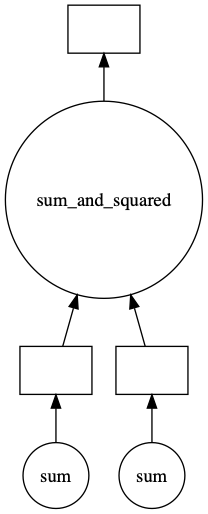

In [45]:
result.visualize()

As we see, Dask first calls two `sum` functions separately and then combine their results to feed into `sum_and_squared` function. This means that the calls to the two `sum` functions can be parallelized.

Now, let's evaluate the result. To this purpose, we just call the `.compute()` function as follows:

In [44]:
result.compute()

196

And we got the result as expected. 

In the next checkpoint, we'll talk about how to use Dask dataframes instead of Pandas dataframes.